# Project 2: Classification with Kernelized Perceptron

## Objectives
Your goal in this project is to get comfortable in implementing kernelized perceptron for classification. To complete this project, you should understand the following:

* How to use basic math and machine learning modules in python such as numpy, matplotlib, and sklearn
* How to train a kernel perceoptron model *from scratch*
* How to select an approprite kernel function for a task.
* How to perform model section when facing multiple choices
* How to evaluate the test results and visualize the outcome of an ML model 

## Deliverable
* Project report/writeup: A `project2_report_lastname.pdf` file with corresponding plots and results for the project. Follow the `Project 2 - Report (Individual Submission)` link on Gradescope to upload this file. The project report should include a brief justification of your solution at a high-level, e.g., using any relevant explanations, equations, or pictures that help to explain your solution. You should also describe what your code does, e.g. using a couple of sentences per function to describe your code structure. 

* Source code: A `project2_src_lastname1[_lastname2].ipynb` (or `.zip`) file with a working copy of your solutions compiled in a Jupyter notebook. Follow the `Project 2 - Source Code (Group Submission)` link to upload this file.


## Logistics

* You can work in groups of 1-2 students for each course project, and it's your responsibility to find a group (e.g. use Ed Discussion). 
* Every member of a group must complete and submit the project report/writeup individually. While the source code can be the same for all group members, the project report needs to be written independently by each person and, thus, should differ among team member and students more generally.
* One one group member need to submit the source code. If you submit as a group, make sure to include your teammate in the group submission. Instructions for team submission can be found [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).
* Grades will be provided based on the individual project report. The source code submission will not be graded, but the teaching staff may check the source files if they see the need for reproducing your results when going through your project report. 
* Failure to submit the source code will lead to a deduction of points from your total.


# Task 2A (60pts)
In this problem, you will use perceptron to deal with a 2-D classification problem.

## Dataloader
The reference code for generating the training and test set (and plot) is provided as below.



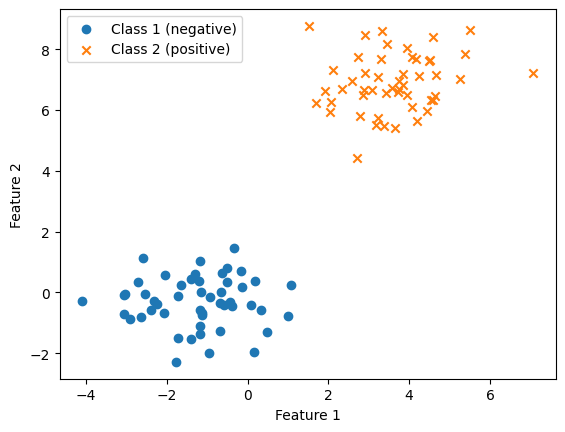

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg
from sklearn.metrics import accuracy_score

from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from scipy.optimize import minimize_scalar


# fix random seed for reproducibility
np.random.seed(40)

# Step 1: Define dataset parameters
num_samples = 100
dimensionality = 2
num_classes = 2

# Step 2: Generate random data points for each class
mean_class1 = np.random.randn(dimensionality) * 2
mean_class2 = np.random.randn(dimensionality) * 2 + 5
data_class1 = mean_class1 + np.random.randn(num_samples // 2, dimensionality)
data_class2 = mean_class2 + np.random.randn(num_samples // 2, dimensionality)

# Step 3: Assign class labels (-1 for class 1 and 1 for class 2)
labels_class1 = -np.ones(num_samples // 2)
labels_class2 = np.ones(num_samples // 2)

# Step 4: Combine data and labels, and shuffle the dataset
data = np.vstack((data_class1, data_class2))
labels = np.hstack((labels_class1, labels_class2))
permutation = np.random.permutation(num_samples)
data = data[permutation]
labels = labels[permutation]

# Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
split_ratio = 0.8
Xtrain, Xtest, ytrain, ytest = train_test_split(data, labels, test_size=1-split_ratio, random_state=42)

# Visualize the dataset (optional)
plt.scatter(data_class1[:, 0], data_class1[:, 1], label='Class 1 (negative)', marker='o')
plt.scatter(data_class2[:, 0], data_class2[:, 1], label='Class 2 (positive)', marker='x')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

## Task 2A.1. Perceptron (25pts)

In this section, we are going to implement a binary classifier with the `Perceptron` class. 

<span style="color:red"> TODO: </span> Fill in the code in the `Perceptron` class to implement the `fit`, `project`, and `predict` methods.

In [9]:
class Perceptron(object):
    def __init__(self, T=1):
        self.T = T # number of iterations
        
    def fit(self, X, y):
        """
        Train perceptron model on data X with labels y and iteration T.
        """
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features, dtype=np.float64)
        self.b = 0.0
        #### TODO: YOUR CODE HERE ####
        for _ in range(self.T):
            for i in range(n_samples):
                if self.predict(X[i])[0] != y[i]:
                    self.w += y[i] * X[i]
                    self.b += y[i]        

    def project(self, X):
        """
        Project data X onto the learned hyperplane with weights w and bias b.
        """
        #### TODO: YOUR CODE HERE ####
        return (X @ self.w) + self.b

    def predict(self, X):
        """
        Predict class labels for samples in X. Must use the project method.
        """
        X = np.atleast_2d(X)

        #### TODO: YOUR CODE HERE ####
        proj = self.project(X)

        y_hat = np.zeros(proj.shape[0])
    
        for i in range(proj.shape[0]):
            if proj[i] >= 0:
                y_hat[i] = 1
            else:
                y_hat[i] = -1
        
        return y_hat

Then we evaluate its accuracy and plot the decision boundary:

In [10]:
model = Perceptron(T=5)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
print('Accuracy: %.2f%%' % (np.mean(ypred == ytest) * 100))

Accuracy: 100.00%


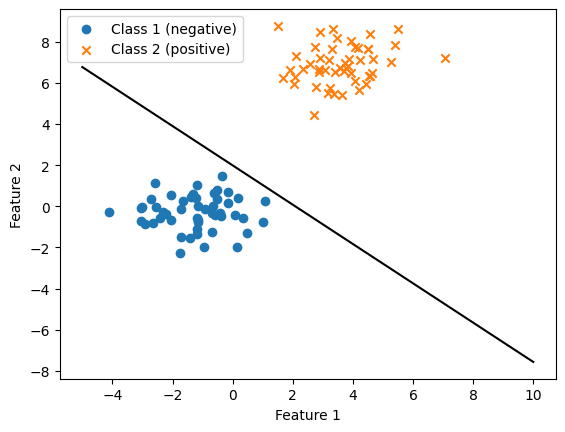

In [11]:
# Plot the decision boundary
w = model.w
b = model.b
x1 = np.linspace(-5, 10, 100)
x2 = (-w[0] * x1 - b) / w[1]
plt.plot(x1, x2, 'k-')
plt.scatter(data_class1[:, 0], data_class1[:, 1], label='Class 1 (negative)', marker='o')
plt.scatter(data_class2[:, 0], data_class2[:, 1], label='Class 2 (positive)', marker='x')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

## Task 2A.2. Kernel Trick (35pts)

Recall that in class ("Kernel Methods"), we discussed the *Kernel Perceptron* algorithm. The decision function for the Kernel Perceptron is given by

$$
f(\mathbf{x}) = \text{sign}\left(\sum_{i=1}^{n} \alpha_i y_i k(\mathbf{x}_i, \mathbf{x})\right)
$$

where $k(\mathbf{x}_i, \mathbf{x})$ is the kernel function, $\alpha_i$ are the learned weights, and $y_i$ are the labels.

The kernel (Gram) matrix induced by kernel function *k* over *n* data points is defined as

$$
\mathbf{K}=
\left(\begin{array}{ccc} 
k(\mathbf{x}_1,\mathbf{x}_1) & \dots & k(\mathbf{x}_1,\mathbf{x}_n)\\
\vdots & \ddots & \vdots \\
k(\mathbf{x}_n,\mathbf{x}_1) & \dots & k(\mathbf{x}_n,\mathbf{x}_n)
\end{array}\right)
$$ 

Given a test data point **x**, the predicted label is

$$
\hat{y} = \text{sign}\left(\sum_{i=1}^{n} \alpha_i y_i k(\mathbf{x}_i, \mathbf{x})\right)
$$

The Kernel Perceptron algorithm iteratively updates the weights $\alpha_i$ based on the misclassified points in the training set (please refer to lecture notes on "kernel").

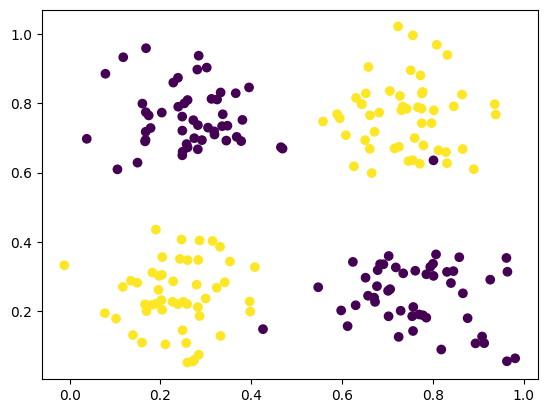

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Fix random seed for reproducibility
np.random.seed(42)

# Number of samples per quadrant
n = 50

# Standard deviation for Gaussian distribution
std_dev = 0.1

# Quadrant 1 and 3: label 1
q1 = np.random.normal(loc=[0.25, 0.25], scale=std_dev, size=(n, 2))
q3 = np.random.normal(loc=[0.75, 0.75], scale=std_dev, size=(n, 2))

# Quadrant 2 and 4: label -1
q2 = np.random.normal(loc=[0.75, 0.25], scale=std_dev, size=(n, 2))
q4 = np.random.normal(loc=[0.25, 0.75], scale=std_dev, size=(n, 2))

X = np.vstack((q1, q3, q2, q4))
y = np.hstack((np.ones(2*n), -np.ones(2*n)))

# Split the data into training and testing sets
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Visualize the dataset
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

The code below plots the decision boundary

In [13]:
# Plot the decision boundary
def plot_decision_bounday_kernel_perceptron(model, ax=None):
    x1 = np.linspace(0, 1, 50)
    x2 = np.linspace(0, 1, 50)
    xx1, xx2 = np.meshgrid(x1, x2)
    Z = np.zeros(xx1.shape)
    for i in range(xx1.shape[0]):
        for j in range(xx1.shape[1]):
            Z[i,j] = model.predict([xx1[i,j], xx2[i,j]])
    if ax is None:
        fig, ax = plt.subplots()

    # Plot the decision boundary and the data
    contour = ax.contourf(xx1, xx2, Z, alpha=0.4)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k')

    return contour, scatter

Recall in lecture, we have seen different kernels for $\mathbb{R}^d$. Here are three common kernels below:

\begin{align*}
k_{\text{poly}}(\mathbf{x},\mathbf{x}', d)&=(1+\mathbf{x}^\top \mathbf{x}')^d.\\
k_{\text{RBF}}(\mathbf{x},\mathbf{x}', \sigma) &= \exp(-\frac{\lVert \mathbf{x}-\mathbf{x'} \rVert^2_2}{2\sigma^2})\\
k_{\text{laplace}}(\mathbf{x},\mathbf{x}', \sigma) &= \exp(-\frac{\lVert \mathbf{x}-\mathbf{x'} \rVert _1}{\sigma})
\end{align*}

<span style="color:red"> TODO: </span> Fill the following code block for kernel functions and kernel perceptron. (You should *not* use the other libraries such as scikit-learn.)

In [14]:
class PolynomialKernel:
    def __init__(self, p=1):
        self.p = p

    def __call__(self, x, y):
        #### TODO: YOUR CODE HERE
        return 

class GaussianKernel:
    def __init__(self, sigma=5):
        self.sigma = sigma

    def __call__(self, x, y):
        #### TODO: YOUR CODE HERE
        return 
    
class LaplaceKernel:
    def __init__(self, sigma=5):
        self.sigma = sigma

    def __call__(self, x, y):
        #### TODO: YOUR CODE HERE
        return 
    
class KernelPerceptron(object):
    def __init__(self, kernel=PolynomialKernel(p = 1), T=1):
        self.kernel = kernel
        self.T = T # number of iterations
        self.alpha = None
        self.Xtrain = None
        self.ytrain = None

    def fit(self, X, y):
        self.Xtrain, self.ytrain = X, y
        n_samples, n_features = X.shape
        self.alpha = np.zeros(n_samples, dtype=np.float64)
        # Gram matrix
        K = np.zeros((n_samples, n_samples))
        #### TODO: YOUR CODE HERE
        
        
    def project(self, X):
        #### TODO: YOUR CODE HERE
        return

    def predict(self, X):
        X = np.atleast_2d(X)
        #### TODO: YOUR CODE HERE
        return 

### Is the data linearly separable?
Try the linear kernel (polynomial with $p = 1$) and plot the decision boundary.

<span style="color:red"> TODO: </span> Report on the performance and behavior of the model. 

In [15]:
## results for linear kernel
model = KernelPerceptron(kernel=PolynomialKernel(p = 1), T=10)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
print('Accuracy: %.2f%%' % (accuracy_score(ytest, ypred) * 100))
plot_decision_bounday_kernel_perceptron(model)

InvalidParameterError: The 'y_pred' parameter of accuracy_score must be an array-like or a sparse matrix. Got None instead.

### Can we do better with more powerful kernels?
<span style="color:red"> TODO: </span> Perform regression with polynomial, Gaussian, and Laplace kernels with different parameters, and visualize the accuracy as the parameter changes. 

Report on their decision boundaries, accuracy, and how the number of epochs required to reach a plateau in accuracy. Analyze what you see.

In [ ]:
#### TODO: YOUR CODE HERE
# perform regression with polynomial kernel

In [ ]:
#### TODO: YOUR CODE HERE
# perform regression with Gaussian kernel

In [ ]:
#### TODO: YOUR CODE HERE
# perform regression with Laplace kernel

# Task 2B: Real-World Data Analysis: Seoul Bike Rental Data (40pts)

In this task, we will analyze the `SeoulBikeData.csv` dataset, which provides information about bike rentals in Seoul. The dataset includes:
- **6 Features**: Weather-related conditions like temperature, humidity, and wind speed.
- **1 Time Feature**: Hour of the day.
- **Target**: The number of rented bikes, with the objective of predicting whether `Rented Bike Count > 500`.

## Steps to Complete:
1. **Load and Explore the Dataset**:
   - Load the `SeoulBikeData.csv` file using `pandas`.
   - Display descriptive statistics and visualize feature distributions (e.g., histograms, pair plots).

2. **Preprocessing**:
   - Convert `Rented Bike Count` into a binary target (`1` if > 500, else `0`).
   - Normalize the numerical features using min-max scaling or standardization.

3. **Kernel-Based Modeling**:
     - **Polynomial Kernel**: $k_{\text{poly}}(\mathbf{x}, \mathbf{x}') = (1 + \mathbf{x}^\top \mathbf{x}')^d$
     - **Gaussian Kernel (RBF)**: $k_{\text{RBF}}(\mathbf{x}, \mathbf{x}') = \exp\left(-\frac{\lVert \mathbf{x} - \mathbf{x}' \rVert_2^2}{2 \sigma^2}\right)$
     
   - Optimize $\sigma$ for the Laplace kernel during training using cross-validation.

4. **Evaluation and Analysis**:
   - Compare the performance of different kernels using accuracy and
   classification reports.
   - Visualize decision boundaries for the Laplace kernel with the optimal $\sigma$ using principle component analysis (PCA) to project data in higher dimensional feature space to 3 dimensions. Then plot the decision boundary in the same graph to visualize. Assuming the features are linearly independent, it would take the full dimension of the feature to capture 100 percent of the variation, however if we assume the data is of low "numerical rank", plotting the first say 3 dominant dimension of the feature will give a good representation of the data.
   - Use `pca_3d = PCA(n_components=3); X_pca_3d = pca_3d.fit_transform(Xtest)` followed by `pca_3d.explained_variance_ratio_` and `np.sum(explained_variance_ratio) * 100:.2f}%` to see how much of the variance is explained by 3 dominant principle component.

In [ ]:
# Unzip the data to the current directory. Change the path or install unzip if needed.
# You may use your OS tool or the following code.
# You can safely comment out this line once the data is unzipped.
!unzip ./pa2_data.zip

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

filename = 'data/SeoulBikeData.csv'
df = pd.read_csv(filename).drop(['Date', 'Seasons', 'Holiday', 'Functioning Day'], axis=1)
df = df.sample(n=1000, random_state=4)
X = df.drop(['Rented Bike Count'],  axis=1)[[
                                            'Hour', 
                                            'Temperature (deg C)', 
                                            'Humidity(%)', 
                                            'Visibility (10m)',
                                            'Dew point temperature (deg C)',
                                            'Solar Radiation (MJ/m2)',
                                            'Rainfall(mm)'
                                            ]]
y = df['Rented Bike Count'].values
# binarize y
y = np.where(y <= 500, -1, 1)

print(f"Shape X {X.shape}")
print(f"Shape y {y.shape}")
print("y distribution: ", np.unique(y, return_counts=True))

X = StandardScaler().fit_transform(X)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)
Xtrain, Xval = Xtrain[:int(len(Xtrain)*0.8)], Xtrain[int(len(Xtrain)*0.8):]
ytrain, yval = ytrain[:int(len(ytrain)*0.8)], ytrain[int(len(ytrain)*0.8):]

### Kernel Selection ###

<span style="color:red"> TODO: </span> Find a proper kernel function to solve the classification task. 

1. Identify and implement a new kernel function of your choice, e.g., sigmoid kernel. 

2. Use two other kernels used in 2A, namely `PolynomialKernel` and `GaussianKernel`. 

3. Try to optimize hyperparameter(s) of each kernel. Please do a bit of background research and select a range of 5 values for the parameters that seem reasonable and create an additional `val` split from the training data to select the optimal hyperparameter. Then train a model using the best hyperparameter(s) on the whole training set and test the model on the test set. Justify in your report your choice for the 5 values. 

Discuss how accuracy compares across all methods. 

Discuss the difference between the accuracy for data you use to train the model and data the model has not seen. (i.e study the generalization error for each model). What is overfitting in this context?

*Note: Depending on your implementation, this may take several minutes to run. If you find that it is taking prohibitively long, try to optimize your code. A reasonable accuracy can range from 60% to 80% depending on the selected kernel.* 

In [181]:
#### TODO: YOUR CODE HERE
class NewKernel(object):
    def __init__(self):

    def __call__(self, x, y):
        return 

In [ ]:
# find best hyperparameter for a kernel from Task 2A

In [ ]:
# find best hyperparameter for another kernel from Task 2A

In [ ]:
# find best hyperparameter for your new kernel

In [ ]:
# plot data on projected PCA axis in 3d, 
# show much how variance is explained by 3 dominant principal components
# (see evaluation and analysis for details)

# Task 2C (Bonus) Feature Selection (20 pts)

In this task, we will implement and analyze 2 feature selection methods.

## Task 2C.1. Greedy forward selection (10pts)
The full dataset is re-imported below. Note the features of `X`.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

filename = 'data/SeoulBikeData.csv'
df = pd.read_csv(filename).drop(['Date', 'Seasons', 'Holiday', 'Functioning Day'], axis=1)
df = df.sample(n=1000, random_state=4)
X = df.drop(['Rented Bike Count'],  axis=1)
display(df.head())
feature_names = X.columns
y = df['Rented Bike Count'].values
# binarize y
y = np.where(y <= 500, -1, 1)

print(f"Shape X {X.shape}")
print(f"Shape y {y.shape}")
print("y distribution: ", np.unique(y, return_counts=True))

X = StandardScaler().fit_transform(X)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

 Recall the greedy backward selection algorithm in class. The version you will implement below should use an averaged cross-validated accuracy.

The Greedy forward feature selection algorithm (using accuracy):

Initialize $S = \emptyset, A_0 = -1$. Then for $i = 1, \dots, d$, find the best element to add $$s_i = \arg\max_{j \in S} {A_{cv}(S \cup \set{j})}$$
with the corresponding maximum accuracy $A_i = A_{cv}(S \cup \set{s_i})$. If $A_{i+1} < A_i$, break, else set $S = S \cup \set{s_i}$.

<span style="color:red"> TODO: </span> Finish the implementation of cross validation using accuracy as the metric.

In [199]:
def accuracy_cross_validation(Xtrain, ytrain, model, k = 10):
    m = len(ytrain)
    fold_size = m//k
    accuracy_list = []
    for i in range(k):
        tr_idx = list(range(i*fold_size)) + list(range((i+1) * fold_size, m))
        val_idx = list(range(i * fold_size, (i+1) * fold_size))
        #### TODO: YOUR CODE HERE
        
    return np.mean(accuracy_list)

<span style="color:red"> TODO: </span> Implement the greedy forward feature selection algorithm. Your output should contain a list of indices, corresponding to the chosen features.

In [200]:
def greedy_forward(Xtrain, ytrain, k = 5):
    d = Xtrain.shape[1]
    S = []
    V = list(range(d))
    best_acc = -1
    best_acc_list = []
    for _ in range(d):
        #### TODO: YOUR CODE HERE
        pass
        
    return S, best_acc_list

The code below plots cross validated accuracy against the number of features added.

In [ ]:
S, best_acc_list = greedy_forward(Xtrain, ytrain)
print(f'The chosen features are: {feature_names[S]}')
n_features = len(S)
plt.figure()
plt.plot(np.arange(n_features) + 1, best_acc_list)
plt.xlabel("Number of features")
plt.ylabel("Accuracy")
plt.xticks(np.arange(n_features) + 1)
plt.show()

<span style="color:red"> TODO: </span> Discuss:
1. Which features were added? Note the order in which they were added. Does that surprise you?
2. Is there any plateauing behavior? If so, can you make a conclusion about the set of features that **really** mattered?

<span style="color:red"> TODO: </span> Evaluate the performance using the chosen set of features on the test set. Be careful about which set you fit your model on.

In [ ]:
#### TODO: YOUR CODE HERE

## Task 2C.2. L-1 SVM (10 pts)

In this task, you will implement the L1-SVM. For sake of simplicity, kernelized SVM will not be necessary here.

The loss function for the L1-SVM is

$$
    L = \frac{1}{n} \sum_{i=1}^n \max(0, 1 - y_i \mathbf{w}^T \mathbf{x}_i) + \lambda \lVert w \rVert_1 
$$

where we have the hinge loss and a $L_1$ regularization term.


<span style="color:red"> TODO: </span> Implement the L1-SVM loss and grad functions.

In [152]:
def lossFunctionL1SVM(w, X, y, lambda_):
    #### TODO: YOUR CODE HERE
    return 

def gradientDescent(X, y, initial_w, eta, tolerance, lambda_, max_iter=1000):
    Loss_history =[]
    prev_loss = np.inf
    w = initial_w
    for _ in range(int(max_iter)):
        loss, grad = lossFunctionL1SVM(w, X, y, lambda_)
        Loss_history.append(loss)
        w = w - eta * grad
        if abs(prev_loss - loss) < tolerance:
            break
        prev_loss = loss
    
    return w, Loss_history

<span style="color:red"> TODO: </span> Find the best lambda using cross validation. Plot the cross-validated L1-SVM loss and test L1-SVM loss against lambda.

In [206]:
def cross_validation(Xtrain, ytrain, initial_w, eta, tolerance, lambda_, max_iter=1000, k = 10):
    m = len(ytrain)
    fold_size = m//k
    loss_list = []
    for i in range(k):
        tr_idx = list(range(i*fold_size)) + list(range((i+1) * fold_size, m))
        val_idx = list(range(i * fold_size, (i+1) * fold_size))
        #### TODO: YOUR CODE HERE
        
    return np.mean(loss_list)

In [ ]:
lambda_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

cv_loss_list = []
test_loss_list = []

initial_w = np.zeros(Xtrain.shape[1])
eta = 0.01
tolerance = 1e-4

w_list = []
for lambda_ in lambda_list:
    #### TODO: YOUR CODE HERE
    pass

plt.figure(figsize=(10, 6))
plt.plot(lambda_list, cv_loss_list, label='Cross Validation Loss', marker='o')
plt.plot(lambda_list, test_loss_list, label='Test Loss', marker='x')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Loss')
plt.legend()
plt.title('Cross Validation and Test Loss vs Lambda')
plt.show()

<span style="color:red"> TODO: </span> Evaluate the accuracy of the best model.

In [ ]:
#### TODO: YOUR CODE HERE
